Src:
*   [Building image pairs for siamese networks with Python](https://pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/)
*   [Siamese network with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/)
*   [Comparing images for similarity using siamese networks, Keras, and TensorFlow](https://pyimagesearch.com/2020/12/07/comparing-images-for-similarity-using-siamese-networks-keras-and-tensorflow/)





# Building image pairs for siamese networks with Python

In [35]:
from tensorflow.keras.datasets import mnist
from imutils import build_montages
import numpy as np
from google.colab.patches import cv2_imshow
import cv2

In [36]:
def make_pairs(images, labels):
  pairImages = []
  pairLabels = []
  numClasses = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]

    idxB = np.random.choice(idx[label])
    posImage = images[idxB]

    pairImages.append([currentImage, posImage])
    pairLabels.append([1])

    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]

    pairImages.append([currentImage, negImage])
    pairLabels.append([0])

  return (np.array(pairImages), np.array(pairLabels))

In [69]:
(trainX, trainY), (testX, testY) = mnist.load_data()
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

In [38]:
images = []

for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
  imageA = pairTrain[i][0]
  imageB = pairTrain[i][1]
  label = labelTrain[i]

  output = np.zeros((36, 60), dtype="uint8")
  pair = np.hstack([imageA, imageB])
  output[4:32, 0:56] = pair

  text = "neg" if label[0] == 0 else "pos"
  color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)

  vis = cv2.merge([output] * 3)
  vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
  cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
    color, 2)

  images.append(vis)

In [39]:
montage = build_montages(images, (96, 51), (7, 7))[0]

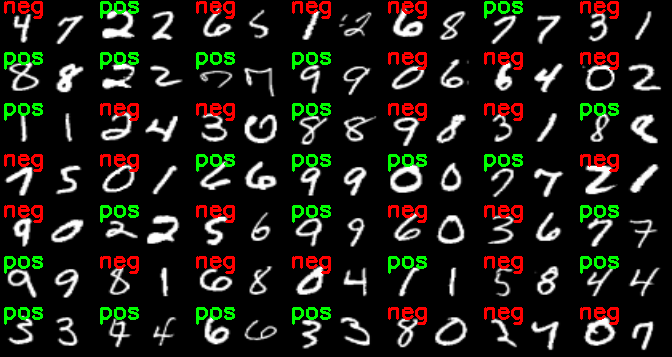

In [40]:
cv2_imshow(montage)

# Siamese network with Keras, TensorFlow, and Deep Learning

In [73]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [114]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 64
EPOCHS = 10

In [141]:
def build_siamese_model(inputShape, embeddingDim=48):
  inputs = Input(inputShape)

  x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)

  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  model = Model(inputs, outputs)

  return model

In [116]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [117]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [118]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [128]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [130]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [143]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7442 - loss: 0.5175 - val_accuracy: 0.7854 - val_loss: 0.4729
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7531 - loss: 0.5057 - val_accuracy: 0.7921 - val_loss: 0.4595
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7603 - loss: 0.4962 - val_accuracy: 0.8080 - val_loss: 0.4287
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7749 - loss: 0.4743 - val_accuracy: 0.8161 - val_loss: 0.4108
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7820 - loss: 0.4641 - val_accuracy: 0.8293 - val_loss: 0.3888
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7875 - loss: 0.4544 - val_accuracy: 0.8182 - val_loss: 0.4015
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7921 - loss: 0.4501 - val_accuracy: 0.8395 - val_loss: 0.3708
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7943 - loss: 0

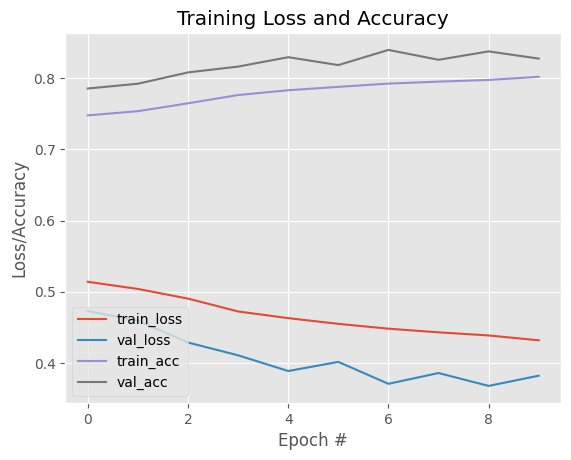

In [145]:
plot_training(history)

In [146]:
model.save("siamese_model.keras")

# Comparing images for similarity using siamese networks, Keras, and TensorFlow

In [53]:
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import argparse

In [54]:
!unzip examples.zip

Archive:  examples.zip
 extracting: examples/img_1.jpg      
 extracting: examples/img_10.jpg     
 extracting: examples/img_100.jpg    
 extracting: examples/img_101.jpg    
 extracting: examples/img_102.jpg    
 extracting: examples/img_103.jpg    
 extracting: examples/img_104.jpg    
 extracting: examples/img_105.jpg    
 extracting: examples/img_106.jpg    
 extracting: examples/img_107.jpg    
 extracting: examples/img_108.jpg    
 extracting: examples/img_109.jpg    
 extracting: examples/img_11.jpg     
 extracting: examples/img_110.jpg    
 extracting: examples/img_111.jpg    
 extracting: examples/img_112.jpg    
 extracting: examples/img_113.jpg    
 extracting: examples/img_114.jpg    
 extracting: examples/img_115.jpg    
 extracting: examples/img_116.jpg    
 extracting: examples/img_117.jpg    
 extracting: examples/img_118.jpg    
 extracting: examples/img_119.jpg    
 extracting: examples/img_12.jpg     
 extracting: examples/img_120.jpg    
 extracting: examples/img_1

In [96]:
testImagePaths = list(list_images("examples"))
np.random.seed(15)
pairs = np.random.choice(testImagePaths, size=(10, 2))

In [83]:
model = load_model("siamese_model.keras", custom_objects={"euclidean_distance": euclidean_distance})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Pair 0: Path A - examples/img_124.jpg, Path B - examples/img_1.jpg


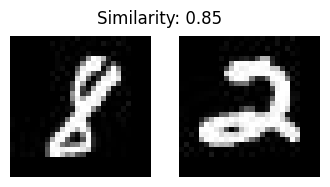

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Pair 1: Path A - examples/img_167.jpg, Path B - examples/img_270.jpg


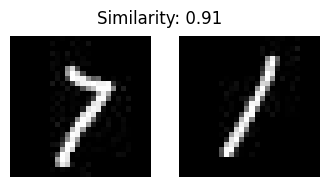

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pair 2: Path A - examples/img_282.jpg, Path B - examples/img_127.jpg


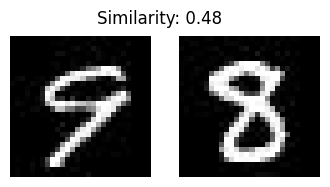

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pair 3: Path A - examples/img_341.jpg, Path B - examples/img_174.jpg


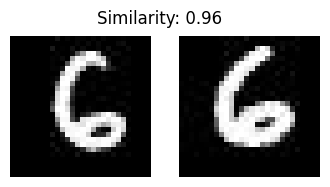

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Pair 4: Path A - examples/img_20.jpg, Path B - examples/img_7.jpg


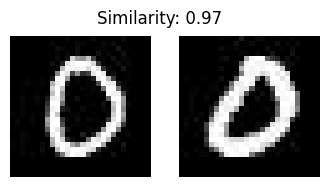

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Pair 5: Path A - examples/img_49.jpg, Path B - examples/img_257.jpg


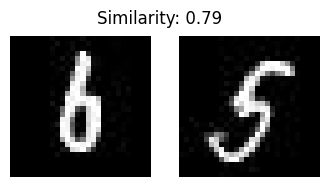

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pair 6: Path A - examples/img_197.jpg, Path B - examples/img_188.jpg


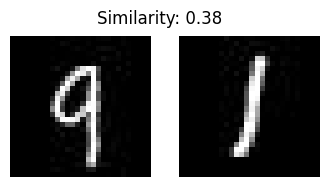

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pair 7: Path A - examples/img_241.jpg, Path B - examples/img_150.jpg


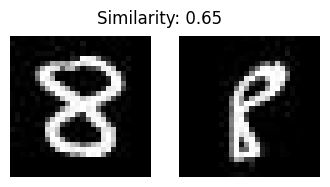

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Pair 8: Path A - examples/img_277.jpg, Path B - examples/img_322.jpg


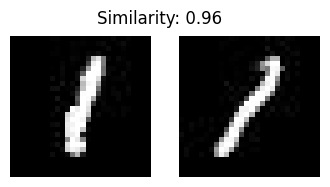

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Pair 9: Path A - examples/img_203.jpg, Path B - examples/img_201.jpg


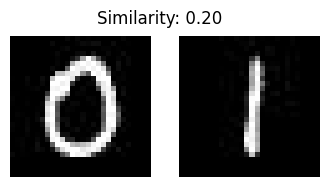

In [144]:
for (i, (pathA, pathB)) in enumerate(pairs):
  imageA = cv2.imread(pathA, 0)
  imageB = cv2.imread(pathB, 0)

  origA = imageA.copy()
  origB = imageB.copy()

  imageA = np.expand_dims(imageA, axis=-1)
  imageB = np.expand_dims(imageB, axis=-1)

  imageA = np.expand_dims(imageA, axis=0)
  imageB = np.expand_dims(imageB, axis=0)

  preds = model.predict([imageA, imageB])
  proba = preds[0][0]

  print(f"Pair {i}: Path A - {pathA}, Path B - {pathB}")

  fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
  plt.suptitle("Similarity: {:.2f}".format(proba))

  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(origA, cmap=plt.cm.gray)
  plt.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(origB, cmap=plt.cm.gray)
  plt.axis("off")

  plt.show()